# Activity

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [163]:
netflix_data = pd.read_csv('data/NFLX.csv', sep=',')

netflix_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


Let's find out more information about the dataset.

In [164]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.6+ KB


As we can see there are no missing values in the dataset. The dataset has 7 columns.
Attributes: 
- Date: Date of the observation
- Open: Opening price of the stock
- High: Highest price of the stock
- Low: Lowest price of the stock
- Close: Closing price of the stock
- Adj Close: Adjusted closing price of the stock
- Volume: Volume of the stock traded

All of the attributes are numerical, only the date is a object.

In [165]:
netflix_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


We can see that the data is from 2002 to 2022 year.

In [166]:
netflix_data.nunique()

Date         4581
Open         4058
High         4036
Low          4021
Close        4120
Adj Close    4120
Volume       4452
dtype: int64

In [167]:
netflix_data.shape[0] - netflix_data.drop_duplicates().shape[0]

0

The are no duplicate rows in the dataset.

Let's convert Date object to the same date format.

In [168]:
netflix_data['Date'] = pd.to_datetime(netflix_data['Date'])
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4581 non-null   datetime64[ns]
 1   Open       4581 non-null   float64       
 2   High       4581 non-null   float64       
 3   Low        4581 non-null   float64       
 4   Close      4581 non-null   float64       
 5   Adj Close  4581 non-null   float64       
 6   Volume     4581 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 250.6 KB


#### Data distribution

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Adj Close'}>],
       [<Axes: title={'center': 'Volume'}>, <Axes: >, <Axes: >]],
      dtype=object)

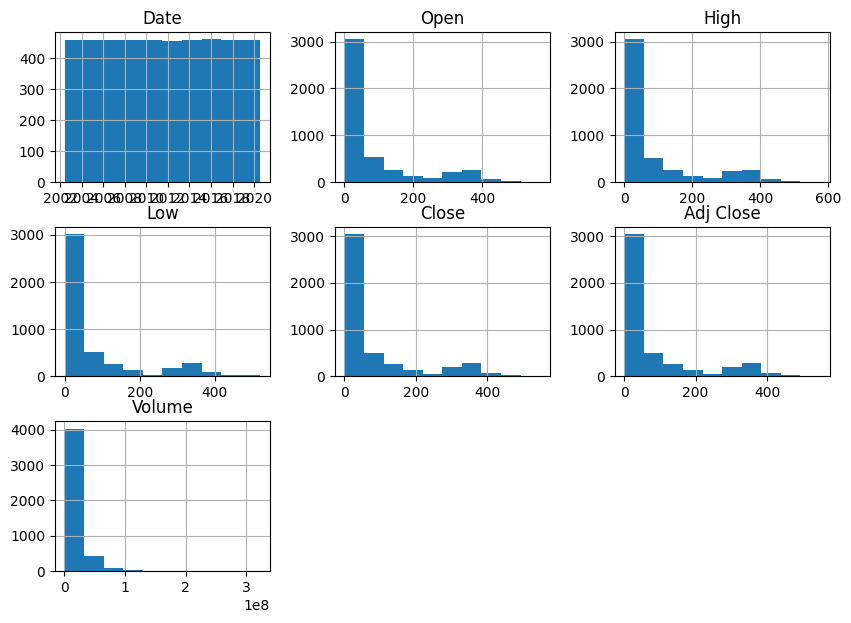

In [169]:
netflix_data.hist(figsize=(10,7))

#### Correlation matrix


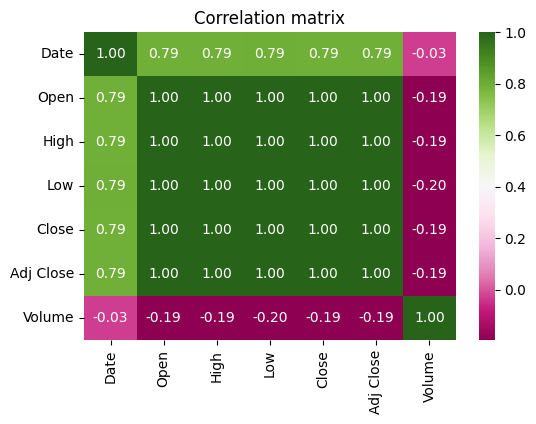

In [170]:
netflix_data_corr = netflix_data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(netflix_data_corr, fmt='.2f', annot=True, cmap='PiYG')
plt.title('Correlation matrix')
plt.show()

Volume has the least correlation with other attributes but in our opinion it still matter, becase the correlation between Volume and stock prices is 0.19 in average, and it is not so low. There are also correlation 1 between Open, High, Low, Close and Adj Close prices. It is obvious that they are highly correlated, because they are the same stock prices, but in different time of the day.

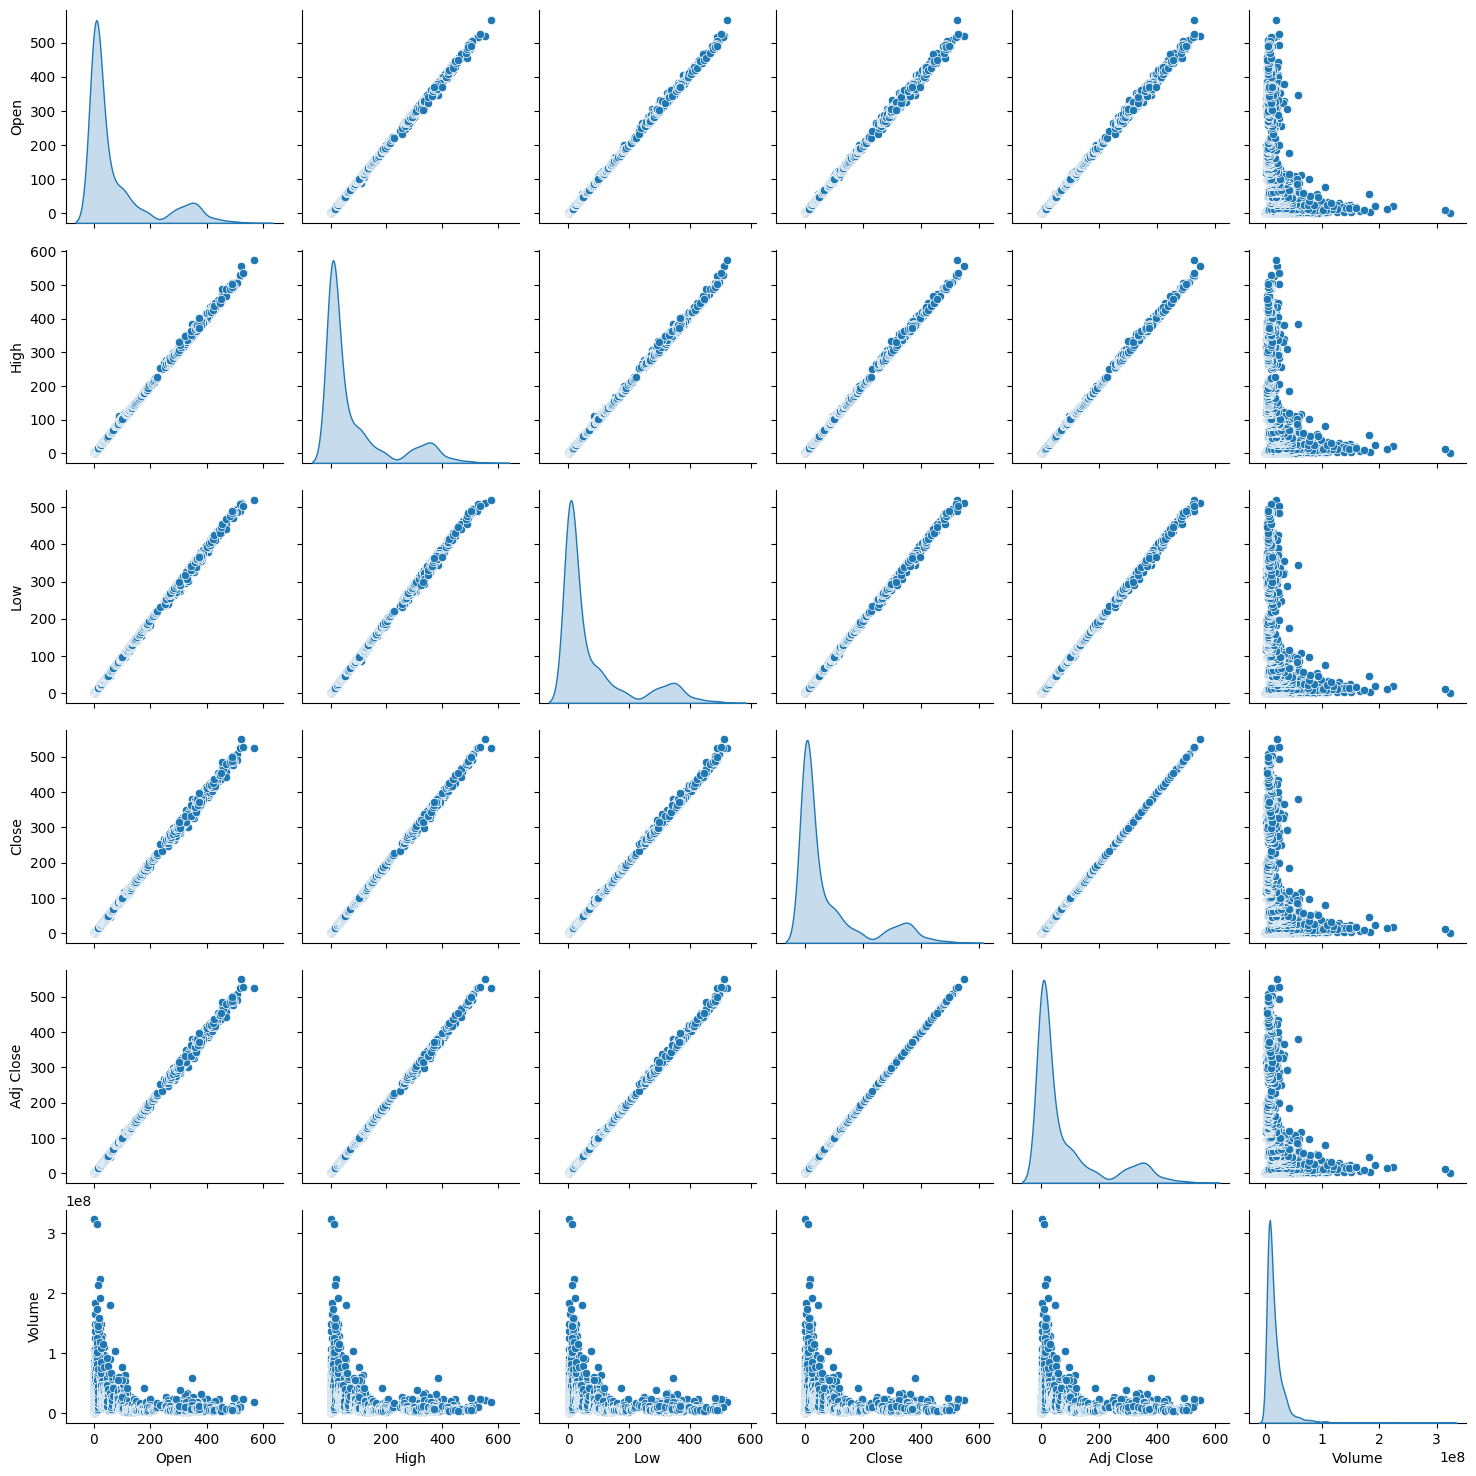

In [171]:
sns.pairplot(netflix_data, diag_kind='kde')

popis laaalalal

### Distribution of the stock prices by years

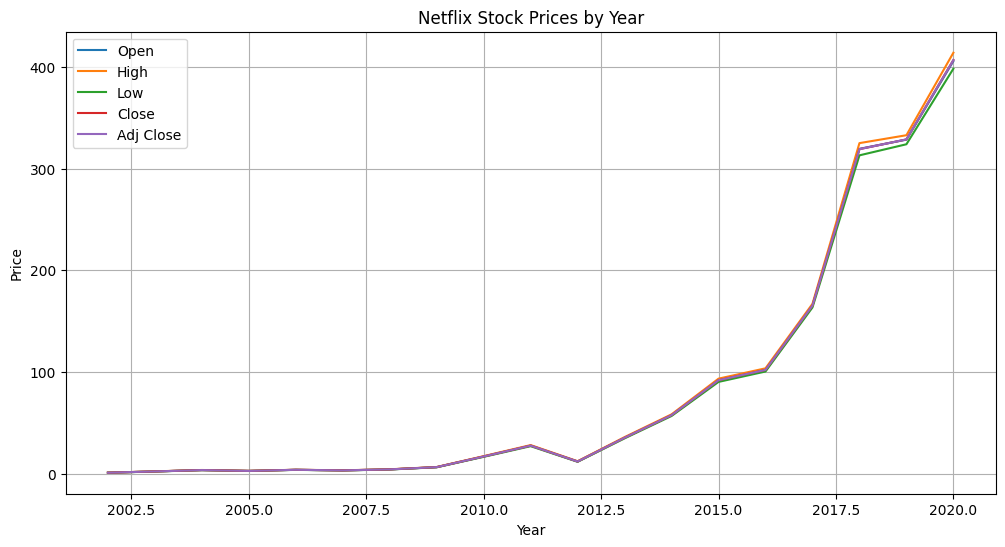

In [208]:
netflix_data['Year'] = netflix_data['Date'].dt.year

yearly_data = netflix_data.groupby('Year').mean()
plt.figure(figsize=(12, 6))
for column in ["Open", "High", "Low", "Close", "Adj Close"]:
    plt.plot(yearly_data.index, yearly_data[column], label=column)

plt.title('Netflix Stock Prices by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


As we can see the stock prices are increasing over the years. It started to significantly increase after 2010 year. The stock prices are pretty simmilar between open, high, low and close prices. We can say that trend is increasing here. And there no seasonality in the stock prices.

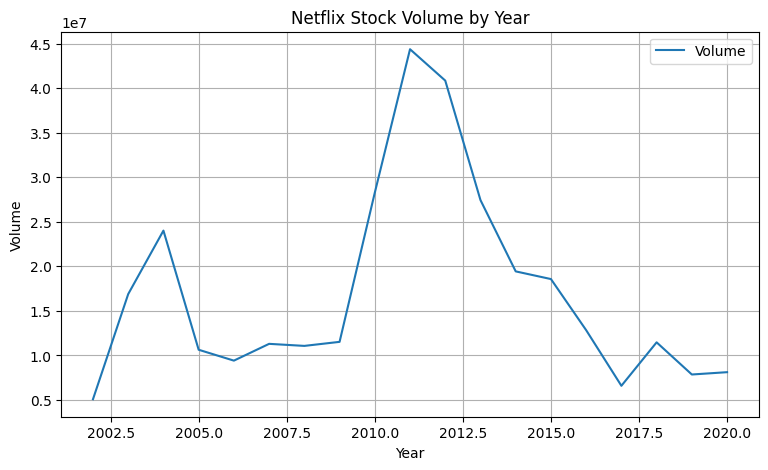

In [204]:
plt.figure(figsize=(9, 5))
for column in ["Volume"]:
    plt.plot(yearly_data.index, yearly_data[column], label=column)

plt.title('Netflix Stock Volume by Year')
plt.xlabel('Year')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()


From the plot above we can see that the highest volume was traded between year 2010 and 2012. After that the volume of the stock traded is decreasing.

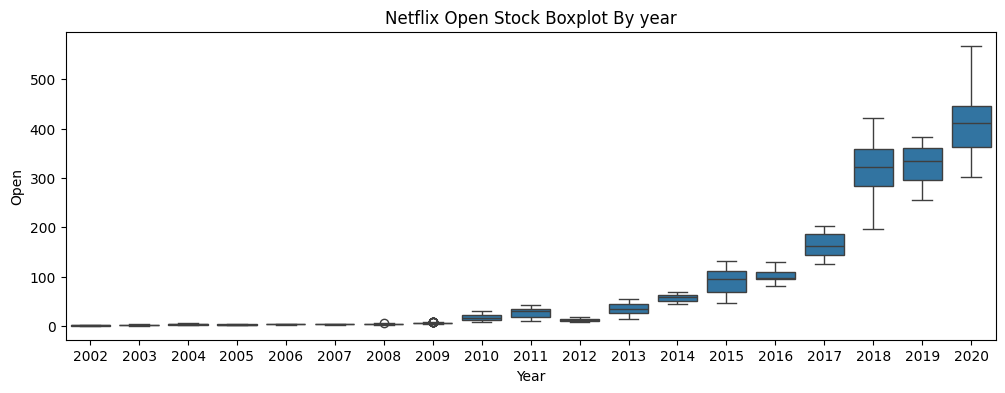

In [214]:
_, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x=netflix_data['Year'], y=netflix_data['Open'], ax=ax)
plt.title('Netflix Open Stock Boxplot By year')
plt.show()

netflix_data = netflix_data.drop(columns=['Year'])

#### Outliers
We deside not to remove outliers, because they are nearly 10% of the all data and also they represent important real-world events that your model should learn from and not just noises or errors in the data.


### Stationarity of the data
Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. So, the values are independent of time.
Let's check the stationarity of the data.

In [220]:

adf_result = adfuller(netflix_data['Volume'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_result[1] <= 0.05:
    print("The time series is stationary (reject null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: -4.780262128254465
p-value: 5.931685508701622e-05
Critical Values:
   1%: -3.4317883367510076
   5%: -2.862175575442719
   10%: -2.5671083199600684
The time series is stationary (reject null hypothesis).


We can see from the test that for attribute Volume the p-value is less than 0.05, so we can reject the null hypothesis and say that the data is stationary. 

In [ ]:
adf_result = adfuller(netflix_data['Open'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_result[1] <= 0.05:
    print("The time series is stationary (reject null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: 2.126079776444259
p-value: 0.998815959771424
Critical Values:
   1%: -3.431788653186758
   5%: -2.862175715236243
   10%: -2.5671083943786552
The time series is non-stationary (fail to reject null hypothesis).


As we can see based on plots above and this ADF test - the data is not stationary. The p-value is 0.99, which is higher than 0.05, so we can't reject the null hypothesis. Also above the test was made for Open attribute, but the results are similar for other price attributes.

We can covert any non-stationary time series into a stationary one by applying a suitable transformation. Mostly statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.

In [ ]:
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] <= 0.05:
        print("The series is stationary (reject null hypothesis).")
    else:
        print("The series is non-stationary (fail to reject null hypothesis).")

In [234]:
def stationarize_data(column):
    time_series = netflix_data[column]

    time_series_log = time_series.apply(lambda x: x if x <= 0 else None).map(lambda x: x) 
    time_series_log = time_series_log=time_series 
    # plt.figure(figsize=(5, 3))
    # plt.plot(time_series_log, label='Log-Transformed Series')
    # plt.title('Log-Transformed Time Series')
    # plt.legend()
    # plt.show()

    time_series_diff = time_series.diff()
    # plt.figure(figsize=(5, 3))
    # plt.plot(time_series_diff, label='Differenced Series (1st Order)')
    # plt.title('1st Order Differenced Time Series')
    # plt.legend()
    # plt.show()

    print("1st Order Differenced Series:")
    check_stationarity(time_series_diff)
    return time_series_diff;

stationarized_data = netflix_data.copy()
stationarized_data['Open'] = stationarize_data('Open')
stationarized_data['High'] = stationarize_data('High')
stationarized_data['Low'] = stationarize_data('Low')
stationarized_data['Close'] = stationarize_data('Close')
stationarized_data['Adj Close'] = stationarize_data('Adj Close')


1st Order Differenced Series:
ADF Statistic: -11.30539123646007
p-value: 1.2770657932700125e-20
Critical Values:
   1%: -3.431788969761772
   5%: -2.8621758550912744
   10%: -2.5671084688299888
The series is stationary (reject null hypothesis).
1st Order Differenced Series:
ADF Statistic: -11.216865830158278
p-value: 2.059262902008958e-20
Critical Values:
   1%: -3.431788969761772
   5%: -2.8621758550912744
   10%: -2.5671084688299888
The series is stationary (reject null hypothesis).
1st Order Differenced Series:
ADF Statistic: -11.382836562897594
p-value: 8.428777721600539e-21
Critical Values:
   1%: -3.431788969761772
   5%: -2.8621758550912744
   10%: -2.5671084688299888
The series is stationary (reject null hypothesis).
1st Order Differenced Series:
ADF Statistic: -11.647849940656908
p-value: 2.071389751830815e-21
Critical Values:
   1%: -3.431788653186758
   5%: -2.862175715236243
   10%: -2.5671083943786552
The series is stationary (reject null hypothesis).
1st Order Differenced

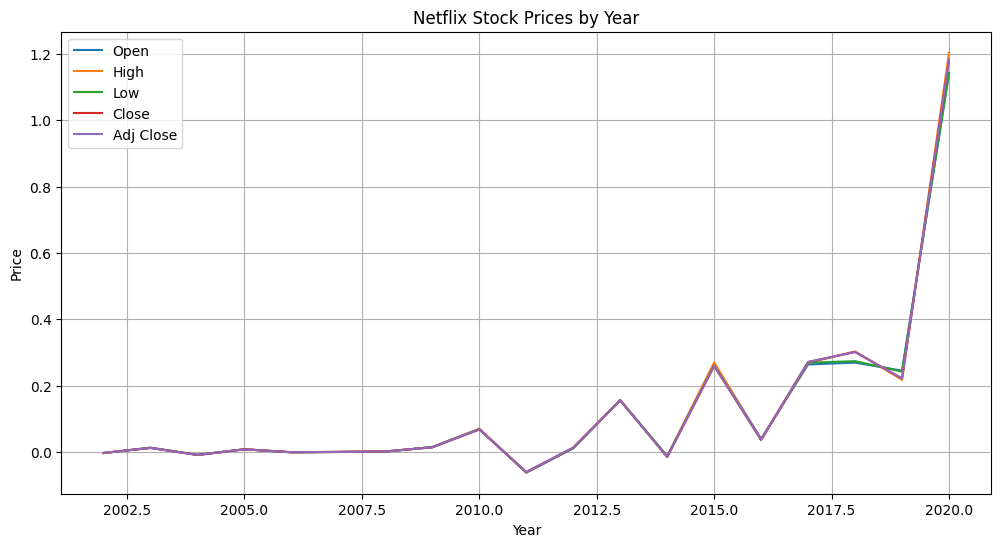

In [242]:
stationarized_data['Year'] = stationarized_data['Date'].dt.year

yearly_data = stationarized_data.groupby('Year').mean()
plt.figure(figsize=(12, 6))
for column in ["Open", "High", "Low", "Close", "Adj Close"]:
    plt.plot(yearly_data.index, yearly_data[column], label=column)

plt.title('Netflix Stock Prices by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
stationarized_data = stationarized_data.drop(columns=['Year'])

This is the graph of the stock prices after applying the log transformation with differencing. We can see that the data is stationary now after ADF test.

Let's split data into train and test data.

In [244]:
train_data, test_data = train_test_split(stationarized_data, test_size=0.15, shuffle=False)

We dont use shuffle here because we are working with time series data and we need to keep the order of the data.

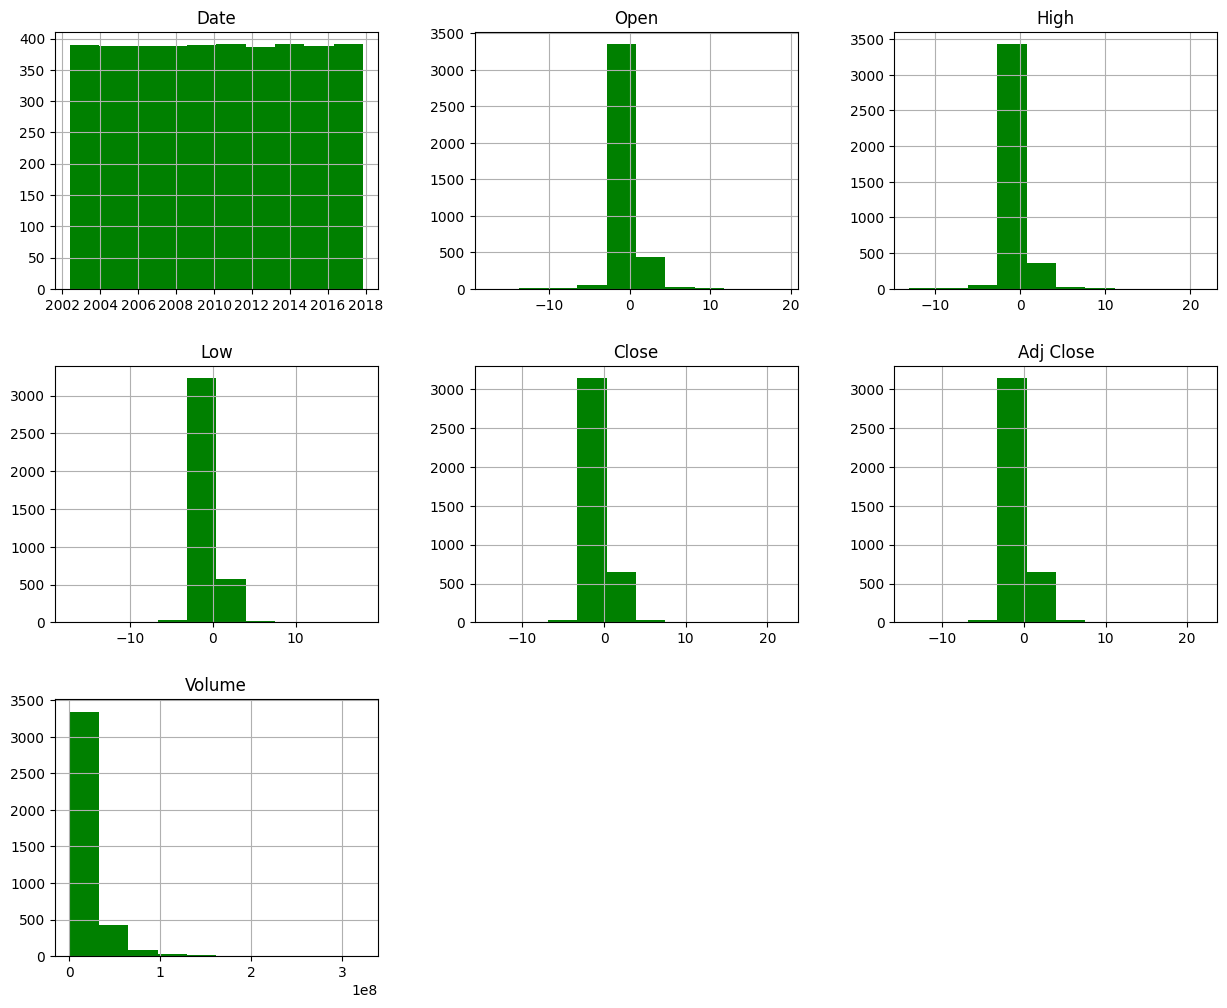

In [245]:
train_data.hist(figsize=(15, 12), color='green')
plt.show()

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Adj Close'}>],
       [<Axes: title={'center': 'Volume'}>, <Axes: >, <Axes: >]],
      dtype=object)

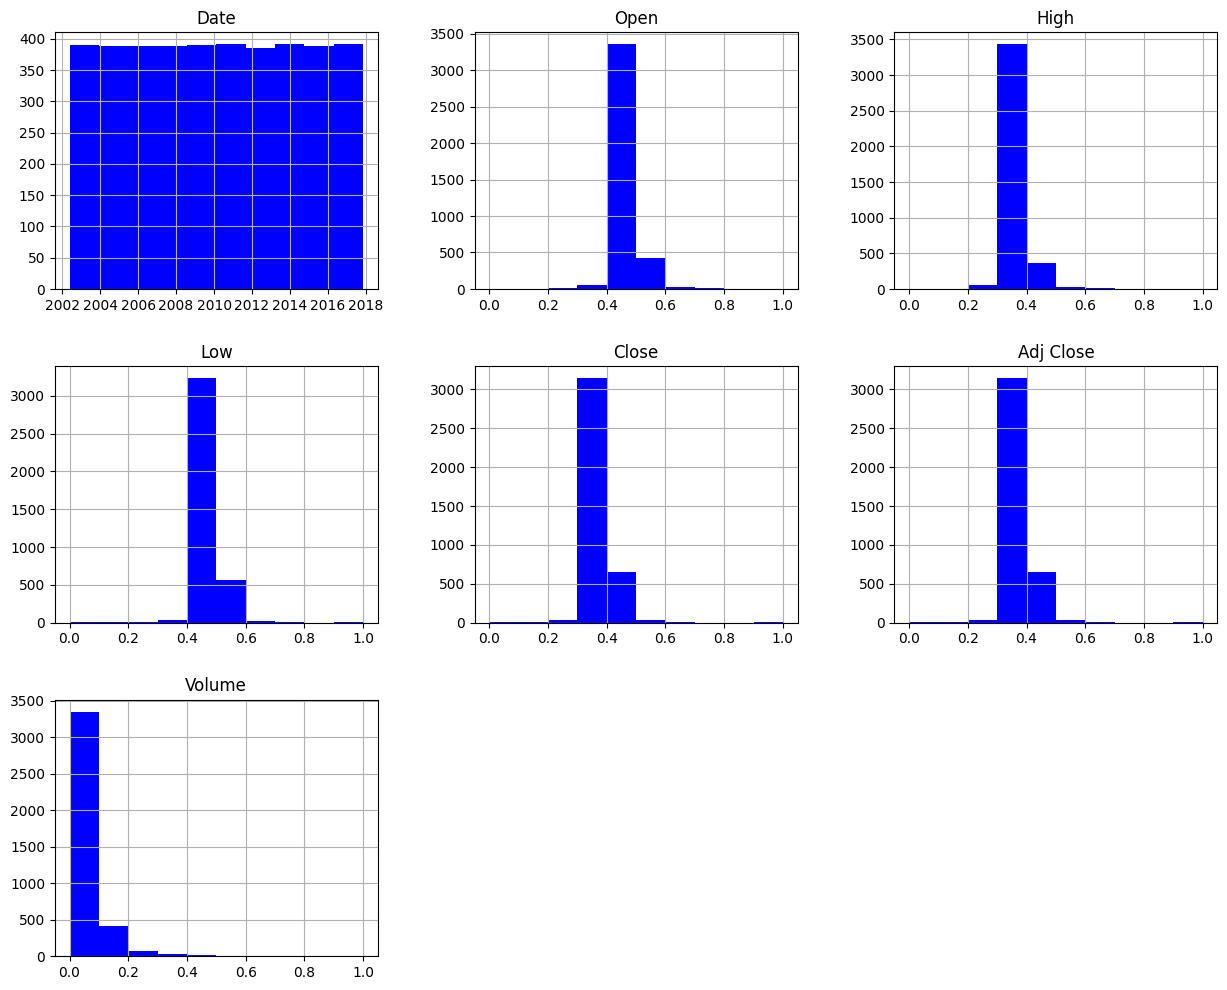

In [255]:
datetime_cols = train_data.select_dtypes(include=['datetime64']).columns
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns

# Scale numeric columns
scaler = MinMaxScaler()
train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])

train_data.hist(figsize=(15, 12), color='blue')

# Forecasting models

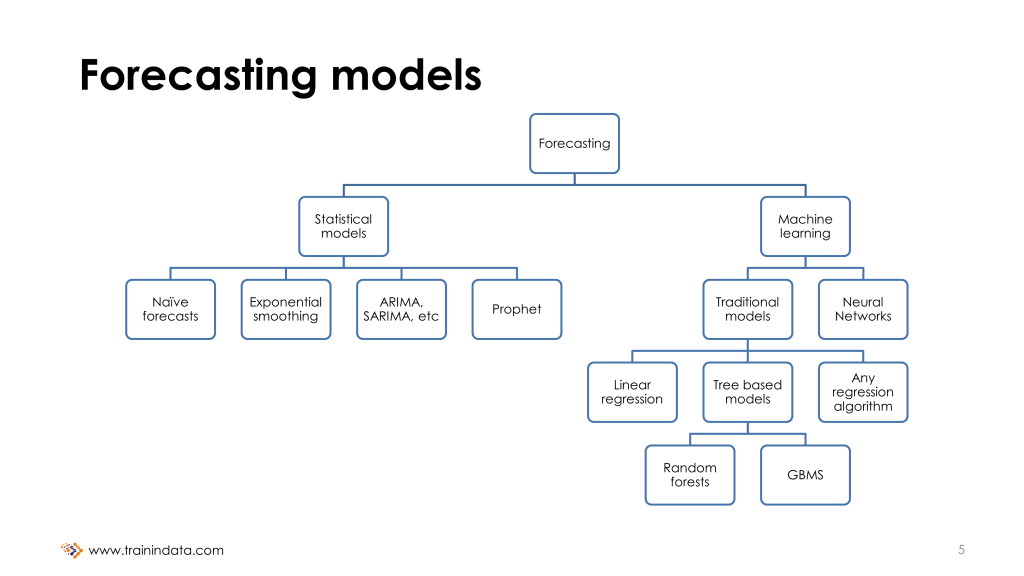

Linear Regression (basic benchmark).
Random Forest Regressor (can handle non-linear relationships).
XGBoost or LightGBM (powerful gradient boosting algorithms).

# Щось з цього що тобі буде легше зробить.